In [1]:
from __future__ import print_function

from datetime import datetime
import sys

from azure.storage.file import FileService
import azure.mgmt.batchai.models as models

# utilities.py contains helper functions used by different notebooks
#sys.path.append('../../')
import utilities

cfg = utilities.Configuration('configuration.json')
client = utilities.create_batchai_client(cfg)
## the below message : Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data') is not a problem
## source https://stackoverflow.com/questions/50123247/azure-python-sdk-authentication-error

Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data')


In [2]:
utilities.create_resource_group(cfg)
_ = client.workspaces.create(cfg.resource_group, cfg.workspace, cfg.location).result()

Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data')


In [3]:

nodes_count = 1
cluster_name = 'nc6'
dsvm=False
if dsvm :
    parameters = models.ClusterCreateParameters(
        location=cfg.location,
        vm_size='STANDARD_NC6',
        scale_settings=models.ScaleSettings(
            manual=models.ManualScaleSettings(target_node_count=nodes_count)
        ), 
        ####### comment out this section when want to use docker image instead of dsvm###########
        virtual_machine_configuration=models.VirtualMachineConfiguration(
            image_reference=models.ImageReference(
                publisher="microsoft-ads",
                offer="linux-data-science-vm-ubuntu",
                sku="linuxdsvmubuntu",
                version="latest")),

        ###################comment out end ####################################
        user_account_settings=models.UserAccountSettings(
            admin_user_name=cfg.admin,
            admin_user_password=cfg.admin_password or None,
            admin_user_ssh_public_key=cfg.admin_ssh_key or None,
        )
    )
else:
    parameters = models.ClusterCreateParameters(
    location=cfg.location,
    vm_size='STANDARD_NC6',
    scale_settings=models.ScaleSettings(
        manual=models.ManualScaleSettings(target_node_count=nodes_count)
    ),
    user_account_settings=models.UserAccountSettings(
        admin_user_name=cfg.admin,
        admin_user_password=cfg.admin_password or None,
        admin_user_ssh_public_key=cfg.admin_ssh_key or None,
    )
    )

location is not a known attribute of class <class 'azure.mgmt.batchai.models.cluster_create_parameters_py3.ClusterCreateParameters'> and will be ignored


In [4]:
_ = client.clusters.create(cfg.resource_group, cfg.workspace, cluster_name, parameters).result()

In [5]:
cluster = client.clusters.get(cfg.resource_group, cfg.workspace, cluster_name)
utilities.print_cluster_status(cluster)

Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0


In [6]:
backend = 'tensorflow'

In [7]:
if backend == 'tensorflow':
    parameters = models.JobCreateParameters(
         location=cfg.location,
         cluster=models.ResourceId(id=cluster.id),
         node_count=1,
         job_preparation=models.JobPreparation(command_line='python -m pip install keras pillow matplotlib numpy'),
        ####### only comment out the below when you use dsvm instead of docker image in parameters block above
         container_settings=models.ContainerSettings(
             image_source_registry=models.ImageSourceRegistry(image='tensorflow/tensorflow:1.8.0-gpu-py3')),
        ######### commend end #########################3
        
         mount_volumes=models.MountVolumes(
            azure_file_shares=[
                models.AzureFileShareReference(
                    account_name=cfg.storage_account_name,
                    credentials=models.AzureStorageCredentialsInfo(
                        account_key=cfg.storage_account_key),
                    azure_file_url='https://{0}.file.core.windows.net/{1}'.format(
                        cfg.storage_account_name, 'bloodcell'), ## bloodcell is the name of the fileshare
                    relative_mount_path='afs')
            ]
         ),
         std_out_err_path_prefix='$AZ_BATCHAI_JOB_MOUNT_ROOT/afs', ## here afs equal to bloodshare level
         tensor_flow_settings=models.TensorFlowSettings(
             python_script_file_path='$AZ_BATCHAI_JOB_MOUNT_ROOT/afs/pretrained_resnet.py',
             master_command_line_args='--train $AZ_BATCHAI_JOB_MOUNT_ROOT/afs/images/TRAIN --val $AZ_BATCHAI_JOB_MOUNT_ROOT/afs/images/TEST --epoch 1 --output $AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ --load_model True')) 

location is not a known attribute of class <class 'azure.mgmt.batchai.models.job_create_parameters_py3.JobCreateParameters'> and will be ignored


In [8]:
experiment_name = 'keras_experiment'
experiment = client.experiments.create(cfg.resource_group, cfg.workspace, experiment_name).result()
job_name = datetime.utcnow().strftime('keras_{}_%m_%d_%Y_%H%M%S'.format(backend))
job = client.jobs.create(cfg.resource_group, cfg.workspace, experiment_name, job_name, parameters).result()
print('Created Job {0} in Experiment {1}'.format(job.name, experiment.name))

Created Job keras_tensorflow_07_23_2018_201215 in Experiment keras_experiment


In [9]:
if backend == 'tensorflow':
    read_file = 'stdout-wk-0.txt'
elif backend == 'cntk':
    read_file = 'stdout.txt'
import utilities

utilities.wait_for_job_completion(client, cfg.resource_group, cfg.workspace, 
                                  experiment_name, job_name, cluster_name, 'stdouterr', read_file)

Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state

112/311 [=========>....................] - ETA: 15:03 - loss: 0.4785 - acc: 0.8167


211/311 [===================>..........] - ETA: 7:44 - loss: 0.4571 - acc: 0.8254


311/311 [==============================] - 1731s 6s/step - loss: 0.4620 - acc: 0.8223 - val_loss: 3.7644 - val_acc: 0.3214
Generating confusion matrix 9957


Found 9957 images belonging to 4 classes.
50
100
150
[[   0  349 2142    6]
 [   0  949 1534    0]
 [   0   97 2381    0]
 [   0  284 2190   25]]
Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.


Token expired or is invalid. Attempting to refresh.
Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data')


[[  0 120 500   3]
 [  0 218 402   0]
 [  0  11 609   0]
 [  0  88 533   3]]
Saved model to disk
Job state: succeeded ExitCode: 0


In [10]:
from azure.storage.file import FileService
file_service = FileService(cfg.storage_account_name, cfg.storage_account_key)
generator = file_service.list_directories_and_files('bloodcell')
for file_or_dir in generator:
    print(file_or_dir.name, file_or_dir.metadata)

best_model.h5 None
best_model.json None
labels.csv None
model.h5 None
model.json None
pretrained_resnet.py None
60be94cf-bd71-4d05-b7ce-d05fb5968d66 None
ChestCTscan None
gans None
images None


In [11]:
_ = client.jobs.delete(cfg.resource_group, cfg.workspace, experiment_name, job_name)

In [12]:
_ = client.clusters.delete(cfg.resource_group, cfg.workspace, cluster_name)

In [13]:
# load json and create model
from keras.models import model_from_yaml
from keras.models import model_from_json

# serialize model to JSON
import os
json_file = open('best_model.json', 'r')
loaded_model_json = json_file.read()
#json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model.h5")
print("Loaded model from disk")
loaded_model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

Using TensorFlow backend.


Loaded model from disk


In [14]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
for i in range(1,5):
    print(dict_characters[i],len(os.listdir('./images/TRAIN/{}'.format(dict_characters[i]))))

NEUTROPHIL 2499
EOSINOPHIL 2497
MONOCYTE 2478
LYMPHOCYTE 2483


In [15]:

import random
import os
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
bloodtype=dict_characters[random.randint(1,4)]
print(bloodtype)
list_files=os.listdir('./images/TEST_SIMPLE/{}'.format(bloodtype))
print(list_files)
f=random.choice(list_files)

NEUTROPHIL
['_0_1966.jpeg', '_10_170.jpeg', '_11_1721.jpeg', '_12_4753.jpeg', '_13_7598.jpeg', '_14_4489.jpeg', '_15_9520.jpeg', '_16_3623.jpeg', '_17_9949.jpeg', '_18_4469.jpeg', '_19_4489.jpeg', '_1_2118.jpeg', '_20_9752.jpeg', '_21_6827.jpeg', '_22_2921.jpeg', '_23_6221.jpeg', '_24_8655.jpeg', '_25_8686.jpeg', '_26_3624.jpeg', '_27_4190.jpeg', '_28_4752.jpeg', '_29_1866.jpeg', '_2_1918.jpeg', '_30_4636.jpeg', '_31_3491.jpeg', '_32_2063.jpeg', '_33_390.jpeg', '_34_3330.jpeg', '_35_5434.jpeg', '_36_5118.jpeg', '_37_3964.jpeg', '_38_4586.jpeg', '_39_1103.jpeg', '_3_1003.jpeg', '_40_7251.jpeg', '_41_2530.jpeg', '_42_8715.jpeg', '_43_289.jpeg', '_44_8974.jpeg', '_45_5733.jpeg', '_46_2162.jpeg', '_47_8207.jpeg', '_4_1395.jpeg', '_5_1480.jpeg', '_6_2289.jpeg', '_7_8956.jpeg', '_8_6417.jpeg', '_9_8786.jpeg']


(197, 197, 3)


C:\Users\zecharpy\AppData\Local\Continuum\anaconda3\envs\pymc_py36\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


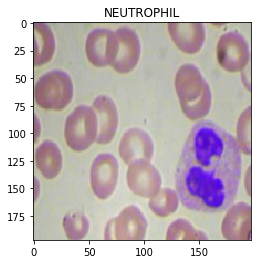

In [16]:
from __future__ import print_function, division

from builtins import range, input

# Note: you may need to update your version of future

# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy import ndimage
import scipy.misc
from glob import glob
%matplotlib inline
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}


img=(plt.imread('./images/TEST_SIMPLE/'+bloodtype+'/'+f).astype(float) - 255.0 / 2)/ 255.0
img=scipy.misc.imresize(img, (197,197,3))

print(img.shape)
plt.imshow(img)
plt.title(bloodtype)
img=img.reshape(-1,197,197,3)

In [17]:
out=loaded_model.predict(img)
print("model prediction is ",dict_characters[np.argmax(out)])

model prediction is  NEUTROPHIL
